In [1]:
"""
Created on Mar 10 2024
@author: Wu Yuxuan
"""

import os
import warnings

import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from matplotlib import pyplot as plt
# import pca from sklearn
from sklearn.decomposition import PCA

/tmp/ipykernel_674477/3716281316.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
seed = 123
warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.10.5.post1
scanpy      0.1.dev3254+g5b9bc72
-----
PIL                 10.2.0
asttokens           NA
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
executing           2.0.1
h5py                3.10.0
igraph              0.11.3
ipykernel           6.29.0
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.41.1
matplotlib          3.8.3
mpl_toolkits        NA
natsort             8.4.0
numba               0.58.1
numpy               1.26.4
packaging           23.2
pandas              2.2.0
parso               0.8.3
patsy               0.5.6
pexpect             4.9.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        4.1.0
prompt_toolkit      3.0.42
psutil              5.9.0
ptyprocess          0.7.0
pure_eval           0.2.2
pydev_ipython       NA
pydevconsole        NA
py

In [3]:
os.chdir('/home/wu/datb1/reseq_ppp')

if "adata_all" in locals():
    del adata_all

sample_list = os.listdir("second_stage_IL_17_treatment")
sample_list = [i for i in sample_list if (i.startswith("PT")) and i.endswith("10X") and 'P99' in i]

# load data
for sample in sample_list:
    # if "P40" in sample:
    #     continue
    print(sample)
    sample_path = os.path.join("second_stage_IL_17_treatment", sample, "filtered_feature_bc_matrix")
    if not os.path.exists(sample_path):
        sample_path = os.path.join("second_stage_IL_17_treatment", sample)
    adata = sc.read_10x_mtx(sample_path, cache=True)
    print(adata.shape)
    adata.obs['batch'] = sample
    adata.obs_names = [sample + '_' + i for i in adata.obs_names]
    adata.obs_names_make_unique()
    # if adata_all is already defined, concat the new adata to it
    if 'adata_all' in locals():
        adata_all = ad.concat([adata_all, adata], uns_merge='unique')
    else:
        adata_all = adata.copy()
        adata_all.uns['batch'] = []
        adata_all.uns['batch_raw'] = {}
    adata_all.uns['batch'].append(sample)
    adata_all.uns['batch_raw'][sample] = len(adata.obs_names)

PT_PPP_P99_1_10X
... writing an h5ad cache file to speedup reading next time
(5924, 33694)
PT_PPP_P99_2_10X
... writing an h5ad cache file to speedup reading next time
(5874, 33694)
PT_PPPC_P99C_10X
... writing an h5ad cache file to speedup reading next time
(6340, 33694)


### step 1: filter cells and genes

In [4]:
adata_all

AnnData object with n_obs × n_vars = 18138 × 33694
    obs: 'batch'
    uns: 'batch', 'batch_raw'

filtered out 1934 cells that have less than 300 genes expressed
filtered out 18336 genes that are detected in less than 50 cells
normalizing counts per cell
    finished (0:00:00)


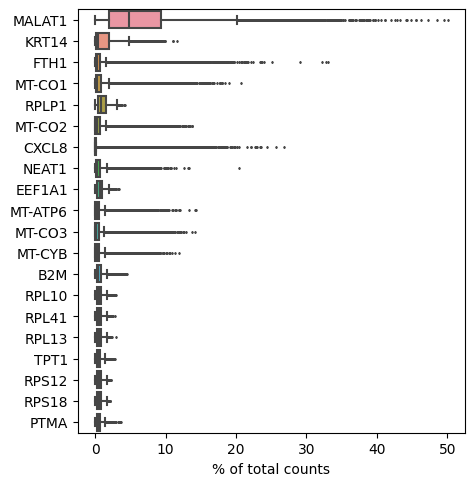

In [5]:
sc.pp.filter_cells(adata_all, min_genes=300)
sc.pp.filter_genes(adata_all, min_cells=50)

sc.pl.highest_expr_genes(adata_all, n_top=20, )

In [6]:
adata_all.var['mt'] = adata_all.var_names.str.startswith('MT-')
adata_all.var['ribo'] = adata_all.var_names.str.startswith(('RPL', 'RPS'))

sc.pp.calculate_qc_metrics(adata_all, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

array([[<Axes: title={'center': 'pct_counts_mt'}>]], dtype=object)

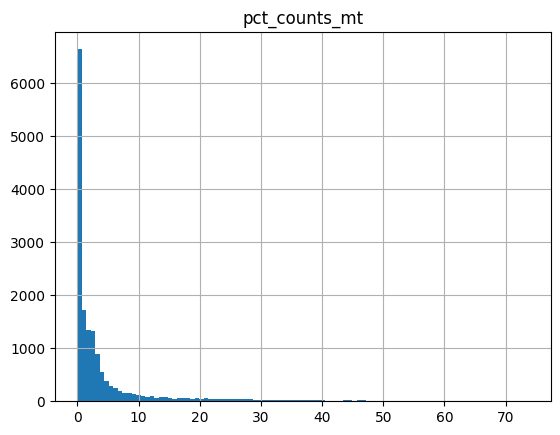

In [7]:
adata_all.obs.hist(column='pct_counts_mt', bins=100)

In [8]:
adata_all.obs.groupby('batch').median()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
batch,,,,,,,
PT_PPPC_P99C_10X,1326.5,1321.0,3344.0,218.5,2.810605,626.0,24.711933
PT_PPP_P99_1_10X,1390.0,1384.0,3770.5,22.0,0.535834,730.0,22.460564
PT_PPP_P99_2_10X,1360.5,1354.5,3362.5,30.0,0.780815,471.5,16.997709


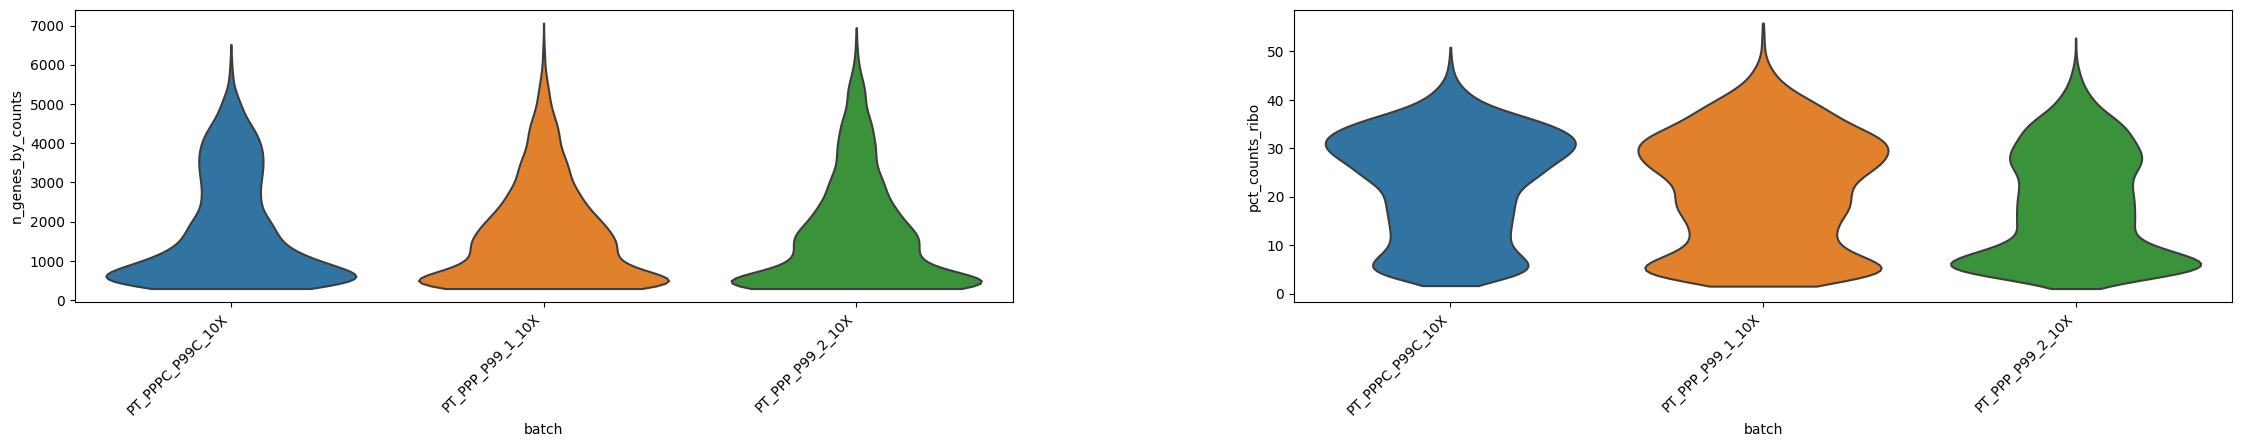

In [9]:
with rc_context({'figure.figsize': (10, 4)}):
    ax = sc.pl.violin(adata_all, ['n_genes_by_counts', 'pct_counts_ribo'], stripplot=False, groupby='batch', show=False)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')

<Axes: xlabel='pct_counts_ribo', ylabel='Count'>

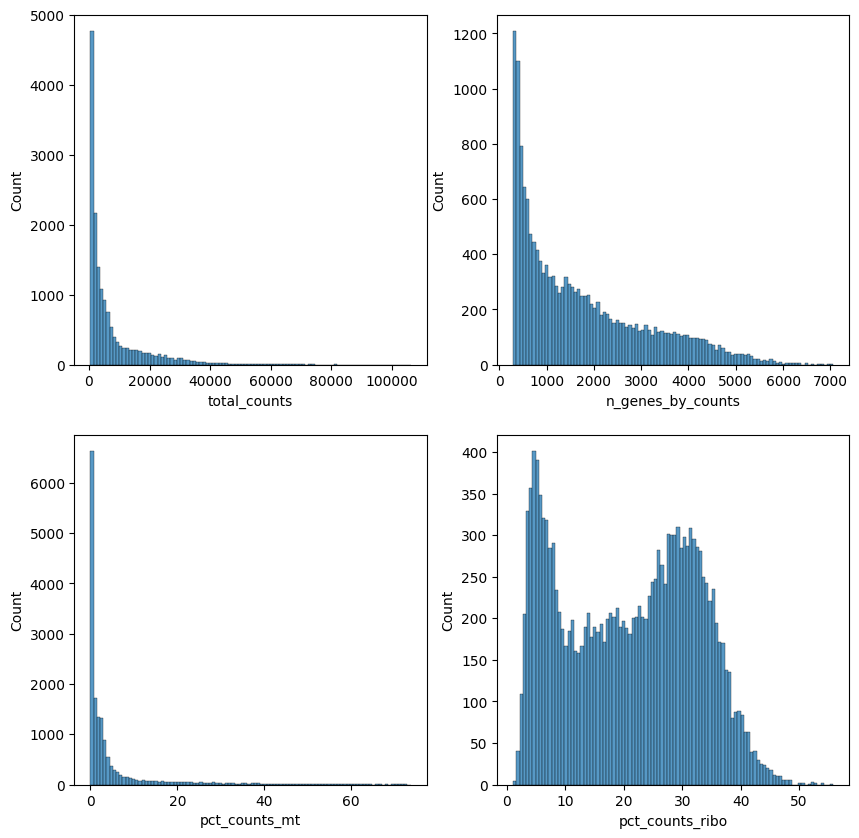

In [10]:
# histplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(adata_all.obs['total_counts'], bins=100, ax=axs[0, 0])
sns.histplot(adata_all.obs['n_genes_by_counts'], bins=100, ax=axs[0, 1])
sns.histplot(adata_all.obs['pct_counts_mt'], bins=100, ax=axs[1, 0])
sns.histplot(adata_all.obs['pct_counts_ribo'], bins=100, ax=axs[1, 1])

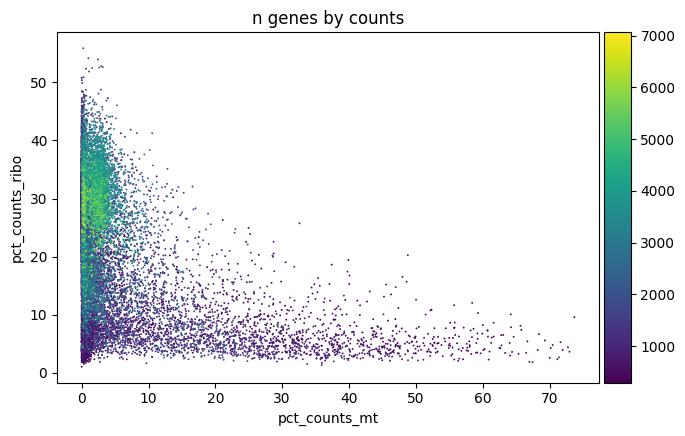

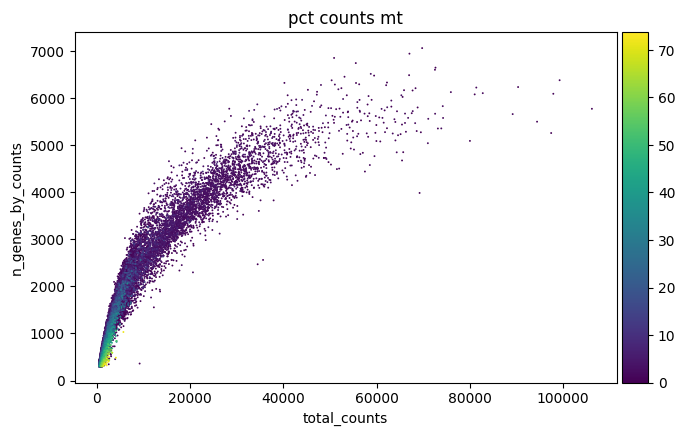

In [11]:
# sc.pl.scatter(adata_all, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_all, x='pct_counts_mt', y='pct_counts_ribo', color='n_genes_by_counts')
sc.pl.scatter(adata_all, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

In [12]:
# filter out cells of more than 40% percent mitochondrial genes
adata_all = adata_all[adata_all.obs.pct_counts_mt < 10, :]
adata_all = adata_all[adata_all.obs.total_counts < 30000, :]

adata_all
# save the raw data
adata_all.write("processed_data/ALL_IL_17_treatment_10X_raw.h5ad")